## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold

from tqdm.auto import tqdm

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

--2021-10-02 23:39:15--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.06s   

2021-10-02 23:39:16 (2.71 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [4]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
status,1,1,2,1,1,1,1,1,1,2
seniority,9,17,10,0,0,1,29,9,0,0
home,1,1,2,1,1,2,2,5,2,5
time,60,60,36,60,36,60,60,12,60,48
age,30,58,46,24,26,36,44,27,32,41
marital,2,3,2,1,1,2,2,1,2,2
records,1,1,2,1,1,1,1,1,1,1
job,3,1,3,1,1,1,1,1,3,2
expenses,73,48,90,63,46,75,75,35,90,90
income,129,131,200,182,107,214,125,80,107,80


Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   seniority  4454 non-null   int64 
 1   home       4454 non-null   object
 2   time       4454 non-null   int64 
 3   age        4454 non-null   int64 
 4   marital    4454 non-null   object
 5   records    4454 non-null   object
 6   job        4454 non-null   object
 7   expenses   4454 non-null   int64 
 8   income     4454 non-null   int64 
 9   assets     4454 non-null   int64 
 10  debt       4454 non-null   int64 
 11  amount     4454 non-null   int64 
 12  price      4454 non-null   int64 
 13  default    4454 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 487.3+ KB


In [10]:
numerical = list(df.select_dtypes(include=['int64']).columns)
print(numerical)

['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default']


In [11]:
categorical = list(df.select_dtypes(include=['object']).columns)
print(categorical)

['home', 'marital', 'records', 'job']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [12]:
df_full_train, df_test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=1
)
df_train, df_val = train_test_split(
    df_full_train, 
    test_size=0.25, 
    random_state=1
)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

In [15]:
numerical.remove('default')
print(numerical)

['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']


In [16]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [17]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [18]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
X_val_scaled = scaler.transform(X_val)

y_pred = model.predict_proba(X_val_scaled)[:, 1]

default_decision = (y_pred >= 0.5)
(y_val == default_decision).mean().round(3)

0.801

In [19]:
accuracy_score(y_val, y_pred >= 0.5).round(3)

0.801

In [20]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

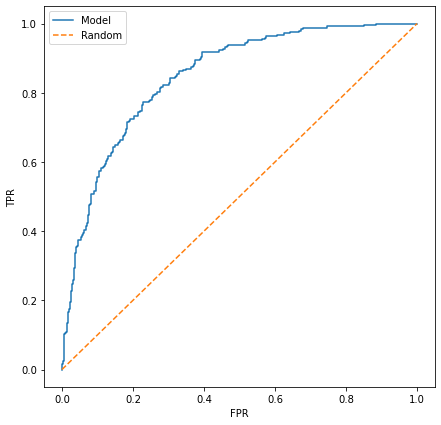

In [21]:
plt.figure(figsize=(7, 7))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [22]:
auc(fpr, tpr).round(3)

0.846

In [23]:
# direct calculation
roc_auc_score(y_val, y_pred).round(3)

0.846

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [24]:
for var in numerical:
    
    auc = roc_auc_score(y_train, df_train[var]).round(3)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var]).round(3)
    
    print("Variable: {}".format(var))
    print("AUC (feature importance): {}".format(auc))
    print("")

Variable: seniority
AUC (feature importance): 0.709

Variable: time
AUC (feature importance): 0.561

Variable: age
AUC (feature importance): 0.573

Variable: expenses
AUC (feature importance): 0.501

Variable: income
AUC (feature importance): 0.682

Variable: assets
AUC (feature importance): 0.649

Variable: debt
AUC (feature importance): 0.505

Variable: amount
AUC (feature importance): 0.591

Variable: price
AUC (feature importance): 0.504



Which categorical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [25]:
selected = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [26]:
df2 = df[selected]

In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   seniority  4454 non-null   int64 
 1   income     4454 non-null   int64 
 2   assets     4454 non-null   int64 
 3   records    4454 non-null   object
 4   job        4454 non-null   object
 5   home       4454 non-null   object
dtypes: int64(3), object(3)
memory usage: 208.9+ KB


In [28]:
categorical2 = list(df2.select_dtypes(include=['object']).columns)
numerical2 = list(df2.select_dtypes(include=['int64']).columns)

In [29]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical2 + numerical2].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [30]:
model = LogisticRegression(
    solver='liblinear', 
    C=1.0, 
    max_iter=1000
)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [31]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
X_val_scaled = scaler.transform(X_val)

y_pred = model.predict_proba(X_val_scaled)[:, 1]

default_decision = (y_pred >= 0.5)
(y_val == default_decision).mean().round(3)

0.782

In [32]:
accuracy_score(y_val, y_pred >= 0.5).round(3)

0.782

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [33]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

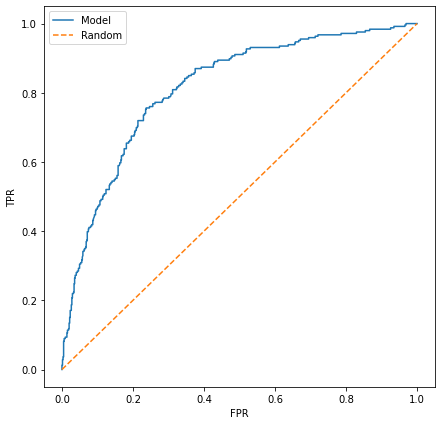

In [34]:
plt.figure(figsize=(7, 7))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [35]:
from sklearn.metrics import auc
auc(fpr, tpr).round(3)

0.813

In [36]:
roc_auc_score(y_val, y_pred).round(3)

0.813

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [37]:
thresholds = np.linspace(0, 1, 101)

precision = []
recall = []

for t in thresholds:
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)        
    r = tp / (tp + fn)        
    
    print('threshold: %.2f precision: %.3f recall: %.3f' % (t, p, r))
    
    precision.append(p)
    recall.append(r)  

threshold: 0.00 precision: 0.276 recall: 1.000
threshold: 0.01 precision: 0.279 recall: 1.000
threshold: 0.02 precision: 0.284 recall: 0.992
threshold: 0.03 precision: 0.291 recall: 0.984
threshold: 0.04 precision: 0.300 recall: 0.984
threshold: 0.05 precision: 0.305 recall: 0.976
threshold: 0.06 precision: 0.313 recall: 0.972
threshold: 0.07 precision: 0.323 recall: 0.967
threshold: 0.08 precision: 0.332 recall: 0.967
threshold: 0.09 precision: 0.340 recall: 0.959
threshold: 0.10 precision: 0.350 recall: 0.955
threshold: 0.11 precision: 0.358 recall: 0.939
threshold: 0.12 precision: 0.371 recall: 0.931
threshold: 0.13 precision: 0.379 recall: 0.931
threshold: 0.14 precision: 0.393 recall: 0.931
threshold: 0.15 precision: 0.405 recall: 0.915
threshold: 0.16 precision: 0.416 recall: 0.911
threshold: 0.17 precision: 0.422 recall: 0.894
threshold: 0.18 precision: 0.433 recall: 0.894
threshold: 0.19 precision: 0.441 recall: 0.882
threshold: 0.20 precision: 0.456 recall: 0.874
threshold: 0.

/home/fool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


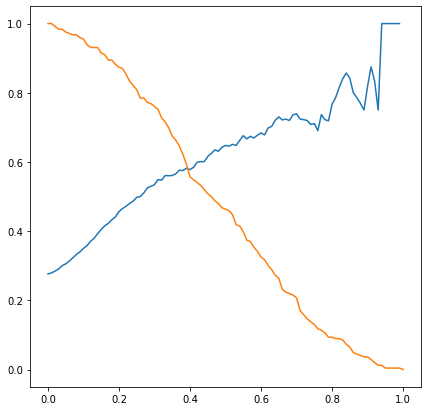

In [38]:
plt.figure(figsize=(7, 7))

plt.plot(thresholds, precision)
plt.plot(thresholds, recall)

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Quesiton 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [39]:
fone = []

for n in range(len(thresholds)):
    f = 2*(precision[n]*recall[n]/(precision[n]+recall[n]))
    t = thresholds[n]
    
    print('threshold: %.2f F1 score: %.3f' % (t, f))
    
    fone.append(f)

threshold: 0.00 F1 score: 0.433
threshold: 0.01 F1 score: 0.437
threshold: 0.02 F1 score: 0.442
threshold: 0.03 F1 score: 0.449
threshold: 0.04 F1 score: 0.460
threshold: 0.05 F1 score: 0.465
threshold: 0.06 F1 score: 0.474
threshold: 0.07 F1 score: 0.484
threshold: 0.08 F1 score: 0.495
threshold: 0.09 F1 score: 0.502
threshold: 0.10 F1 score: 0.513
threshold: 0.11 F1 score: 0.519
threshold: 0.12 F1 score: 0.530
threshold: 0.13 F1 score: 0.539
threshold: 0.14 F1 score: 0.552
threshold: 0.15 F1 score: 0.561
threshold: 0.16 F1 score: 0.571
threshold: 0.17 F1 score: 0.574
threshold: 0.18 F1 score: 0.584
threshold: 0.19 F1 score: 0.588
threshold: 0.20 F1 score: 0.600
threshold: 0.21 F1 score: 0.606
threshold: 0.22 F1 score: 0.608
threshold: 0.23 F1 score: 0.609
threshold: 0.24 F1 score: 0.611
threshold: 0.25 F1 score: 0.616
threshold: 0.26 F1 score: 0.611
threshold: 0.27 F1 score: 0.619
threshold: 0.28 F1 score: 0.625
threshold: 0.29 F1 score: 0.627
threshold: 0.30 F1 score: 0.628
threshol

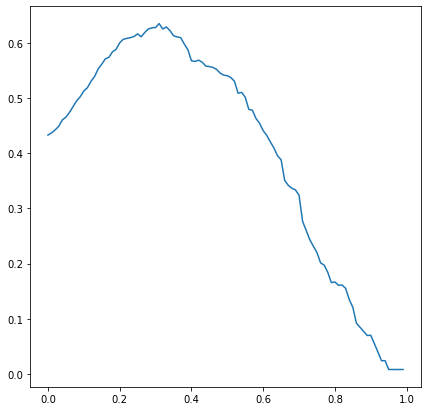

In [40]:
plt.figure(figsize=(7, 7))

plt.plot(thresholds, fone)

In [41]:
print(thresholds[10].round(1), fone[10].round(3))
print(thresholds[30].round(1), fone[30].round(3))
print(thresholds[50].round(1), fone[50].round(3))
print(thresholds[70].round(1), fone[70].round(3))

0.1 0.513
0.3 0.628
0.5 0.54
0.7 0.324


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [42]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical2 + numerical2].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [43]:
dv, model = train(df_train, y_train, C=1.0)

In [44]:
def predict(df, dv, model):
    dicts = df[categorical2 + numerical2].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [45]:
y_pred = predict(df_val, dv, model)

In [47]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [48]:
np.mean(scores).round(3)

0.814

In [49]:
np.std(scores).round(3)

0.015

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [50]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.812 +- 0.014


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.